# DEtection TRansformer (DETR)

DETR is mainly used for object detection tasks, which is the process of detecting objects in an image. For example, the input of the model would be an image of a road, and the output of the model could be [('car',X1,Y1,W1,H1),('pedestrian',X2,Y2,W2,H2)], in which X, Y, W, H represent the x, y coordinates denoting the location of the bounding box, as well as the width and height of the box. A traditional object detection model like YOLO consists of hand-crafted features like anchor box priors, which requires initial guesses of object locations and shapes, affecting downstream training. Post-processing steps are then used to remove overlapping bounding boxes, which require careful selection of its filtering heuristics. DEtection TRansformer, DETR for short, simplifies the detector by using an encoder-decoder transformer after the feature extraction backbone to directly predict bounding boxes in parallel, requiring minimal post-processing.

![](https://huggingface.co/datasets/hf-vision/course-assets/resolve/main/DETR.png)

The model architecture of DETR begins with a CNN backbone, similar to other image-based networks, the output of which is processed and fed into a transformer encoder, resulting in N embeddings. The encoder embeddings are added to learned positional embeddings (called object queries) and used in a transformer decoder, generating another N embeddings. As a final step, each of the N embeddings are put through individual feed forward layers to predict the width, height, coordinates of the bounding box, as well as the object class (or whether there is an object).



In [ ]:
from transformers import DetrImageProcessor, DetrForObjectDetection
import torch
from PIL import Image
import requests

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

# initialize the model
processor = DetrImageProcessor.from_pretrained(
    "facebook/detr-resnet-101", revision="no_timm"
)
model = DetrForObjectDetection.from_pretrained(
    "facebook/detr-resnet-101", revision="no_timm"
)

# preprocess the inputs and infer
inputs = processor(images=image, return_tensors="pt")
outputs = model(**inputs)

# convert outputs (bounding boxes and class logits) to COCO API
# non max supression above 0.9
target_sizes = torch.tensor([image.size[::-1]])
results = processor.post_process_object_detection(
    outputs, target_sizes=target_sizes, threshold=0.9
)[0]

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
        f"Detected {model.config.id2label[label.item()]} with confidence "
        f"{round(score.item(), 3)} at location {box}"
    )

preprocessor_config.json:   0%|          | 0.00/401 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/79.6k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/243M [00:00<?, ?B/s]

Detected cat with confidence 0.998 at location [344.06, 24.85, 640.34, 373.74]
Detected remote with confidence 0.997 at location [328.13, 75.93, 372.81, 187.66]
Detected remote with confidence 0.997 at location [39.34, 70.13, 175.56, 118.78]
Detected cat with confidence 0.998 at location [15.36, 51.75, 316.89, 471.16]
Detected couch with confidence 0.995 at location [-0.19, 0.71, 639.73, 474.17]


## Pytorch implementation

In [ ]:
import torch
from torch import nn
from torchvision.models import resnet50

class DETR(nn.Module):
    def __init__(self, num_classes, hidden_dim, nheads, num_encoder_layers, num_decoder_layers):
        super().__init__()
        self.backbone = nn.Sequential(*list(resnet50(pretrained=True).children())[:-2])
        self.conv = nn.Conv2d(2048, hidden_dim, 1)
        self.transformer = nn.Transformer(
            hidden_dim, nheads, num_encoder_layers, num_decoder_layers
        )
        self.linear_class = nn.Linear(hidden_dim, num_classes + 1)
        self.linear_bbox = nn.Linear(hidden_dim, 4)
        self.query_pos = nn.Parameter(torch.rand(100, hidden_dim))
        self.row_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))
        self.col_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))

    def forward(self, inputs):
        x = self.backbone(inputs)
        h = self.conv(x)

        H, W = h.shape[-2:]
        pos = (
            torch.cat(
                [
                    self.col_embed[:W].unsqueeze(0).repeat(H, 1, 1),
                    self.row_embed[:H].unsqueeze(1).repeat(1, W, 1),
                ],
                dim=-1,
            )
            .flatten(0, 1)
            .unsqueeze(1)
        )
        h = self.transformer(
            pos + h.flatten(2).permute(2, 0, 1), self.query_pos.unsqueeze(1)
        )
        return self.linear_class(h), self.linear_bbox(h).sigmoid()

## Differences Between YOLO and DETR Object Detection

### YOLO
- **Architecture**: YOLO is a single-stage detector that divides an image into a grid and predicts bounding boxes and class probabilities for each grid cell simultaneously. This approach allows for fast inference times, making it suitable for real-time applications.
- **Speed and Efficiency**: YOLO is known for its speed, achieving detection in milliseconds, which is critical for applications like surveillance and autonomous driving. Variants like YOLOv8 have optimized performance further, balancing speed with high accuracy.
- **Use Cases**: Best suited for scenarios requiring real-time detection with moderate computational resources. It's effective in environments where speed is prioritized over absolute precision, such as security monitoring or live video analysis.

### DETR
- **Architecture**: DETR employs a transformer-based architecture that treats object detection as a direct set prediction problem. It predicts bounding boxes and class labels in a single pass without the need for anchor boxes or region proposals.
- **Global Context Awareness**: The self-attention mechanism in transformers allows DETR to capture relationships between objects in an image, improving accuracy in complex scenes where objects are close together.
- **Computational Cost**: While DETR can achieve high accuracy, it typically requires more computational resources and longer training times compared to YOLO. This can limit its practical application in real-time scenarios[3][5].
- **Use Cases**: More effective for tasks involving complex scenes and higher accuracy requirements, such as detailed image analysis or when working with larger datasets. It is beneficial when the relationships between objects are crucial for detection accuracy[2][5].

### When to Use What
- **Choose YOLO**:
  - When speed is critical (e.g., real-time applications).
  - For smaller datasets where rapid inference is necessary.
  - In scenarios where moderate accuracy suffices.

- **Choose DETR**:
  - For complex scenes with overlapping objects.
  - When high accuracy is required, especially in large datasets.
  - If computational resources are available to support longer training times.

## Vision Transformers for Object Detection

The Need to Fine-tune Models in Object Detection 🤔

That is an awesome question. Training an object detection model from scratch means:

Doing already done research over and over again.
Writing repetitive model code, training them, and maintaining different repositories for different use cases.
A lot of experimentation and waste of resources.
Rather than doing all this, take a well-performing pre-trained model (a model which that does an awesome job in recognizing general features), and tweak or re-tune its weights (or some part of its weights) to adapt it for your use case. We believe or assume that the pre-trained model has already learned enough to extract significant features inside an image to locate and classify objects. So, if new objects are introduced, then the same model can be trained for a small period of time and compute to start detecting those new objects with the help of already learned and new features.

Scenario

To make this tutorial interesting, let’s consider a real-world example. Consider this scenario: construction workers require the utmost safety when working in construction areas. Basic safety protocol requires wearing a helmet every time. Since there are many construction workers, it is hard to keep and eye on everyone every time.

But, if we can have a camera system that can detect persons and whether the person is wearing a helmet or not in real-time, that would be awesome, right?

So, we are going to fine-tune a lightweight object detection model for doing just that.

In [ ]:
!pip install -U -q datasets transformers[torch] evaluate timm albumentations accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 57.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.0/224.0 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.9/330.9 kB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 61.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 71.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.3 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset

dataset = load_dataset("anindya64/hardhat")
dataset

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/872 [00:00<?, ?B/s]

(…)-00000-of-00001-3e0d95da2811afee.parquet:   0%|          | 0.00/200M [00:00<?, ?B/s]

(…)-00000-of-00001-9fc2e7e45a21ae43.parquet:   0%|          | 0.00/66.9M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5297 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1766 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'image_id', 'width', 'height', 'objects'],
        num_rows: 5297
    })
    test: Dataset({
        features: ['image', 'image_id', 'width', 'height', 'objects'],
        num_rows: 1766
    })
})

In [ ]:
dataset["train"][0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x375>,
 'image_id': 1,
 'width': 500,
 'height': 375,
 'objects': {'id': [1, 1],
  'area': [3068.0, 690.0],
  'bbox': [[178.0, 84.0, 52.0, 59.0], [111.0, 144.0, 23.0, 30.0]],
  'category': ['helmet', 'helmet']}}

In [ ]:
train_dataset = dataset["train"]
test_dataset = dataset["test"]

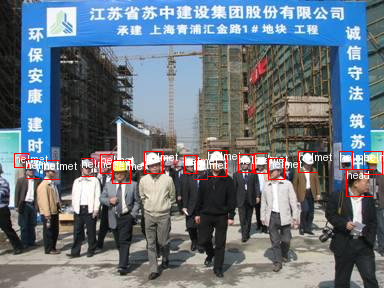

In [ ]:
import numpy as np
from PIL import Image, ImageDraw


def draw_image_from_idx(dataset, idx):
    sample = dataset[idx]
    image = sample["image"]
    annotations = sample["objects"]
    draw = ImageDraw.Draw(image)
    width, height = sample["width"], sample["height"]

    for i in range(len(annotations["id"])):
        box = annotations["bbox"][i]
        class_idx = annotations["id"][i]
        x, y, w, h = tuple(box)
        if max(box) > 1.0:
            x1, y1 = int(x), int(y)
            x2, y2 = int(x + w), int(y + h)
        else:
            x1 = int(x * width)
            y1 = int(y * height)
            x2 = int((x + w) * width)
            y2 = int((y + h) * height)
        draw.rectangle((x1, y1, x2, y2), outline="red", width=1)
        draw.text((x1, y1), annotations["category"][i], fill="white")
    return image


draw_image_from_idx(dataset=train_dataset, idx=10)

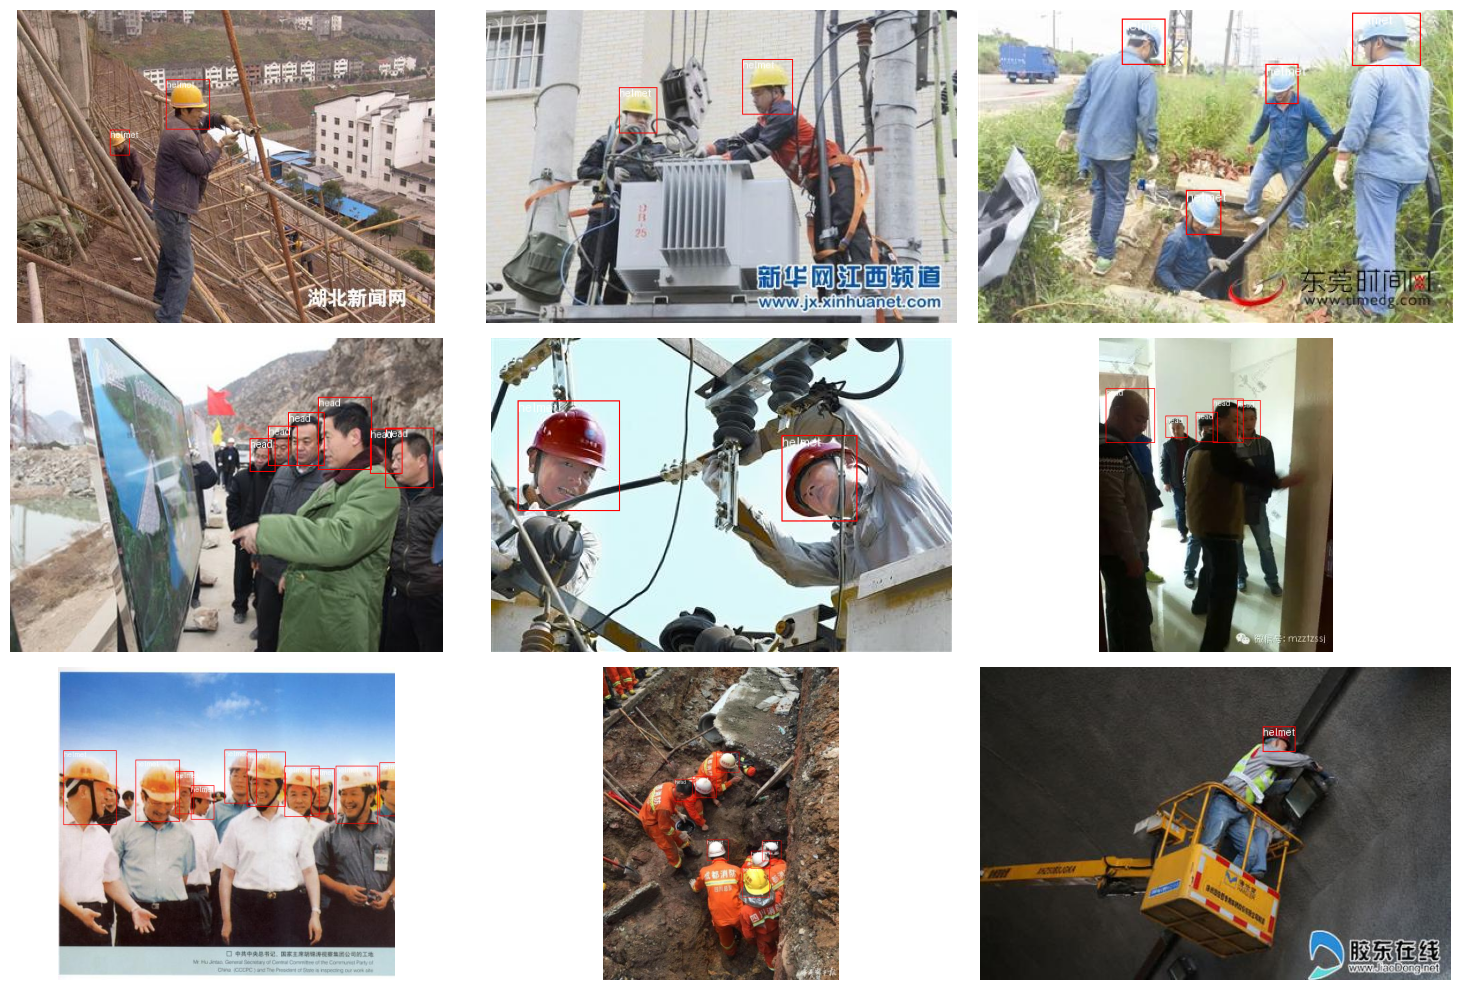

In [ ]:
import matplotlib.pyplot as plt


def plot_images(dataset, indices):
    """
    Plot images and their annotations.
    """
    num_rows = len(indices) // 3
    num_cols = 3
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

    for i, idx in enumerate(indices):
        row = i // num_cols
        col = i % num_cols

        image = draw_image_from_idx(dataset, idx)

        axes[row, col].imshow(image)
        axes[row, col].axis("off")

    plt.tight_layout()
    plt.show()

plot_images(train_dataset, range(9))

Before fine-tuning the model, we must preprocess the data in such a way that it matches exactly with the approach used during the time of pre-training. HuggingFace AutoImageProcessor takes care of processing the image data to create pixel_values, pixel_mask, and labels that a DETR model can train with.

In [ ]:
from transformers import AutoImageProcessor

checkpoint = "facebook/detr-resnet-50-dc5"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

preprocessor_config.json:   0%|          | 0.00/274 [00:00<?, ?B/s]

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


In [ ]:
import albumentations
import numpy as np
import torch

transform = albumentations.Compose(
    [
        albumentations.Resize(480, 480),
        albumentations.HorizontalFlip(p=1.0),
        albumentations.RandomBrightnessContrast(p=1.0),
    ],
    bbox_params=albumentations.BboxParams(format="coco", label_fields=["category"]),
)

In [ ]:
def formatted_anns(image_id, category, area, bbox):
    annotations = []
    for i in range(0, len(category)):
        new_ann = {
            "image_id": image_id,
            "category_id": category[i],
            "isCrowd": 0,
            "area": area[i],
            "bbox": list(bbox[i]),
        }
        annotations.append(new_ann)

    return annotations

In [ ]:
# transform batch
def transform_aug_ann(examples):
    image_ids = examples["image_id"]
    images, bboxes, area, categories = [], [], [], []
    for image, objects in zip(examples["image"], examples["objects"]):
        image = np.array(image.convert("RGB"))[:, :, ::-1]
        out = transform(image=image, bboxes=objects["bbox"], category=objects["id"])

        area.append(objects["area"])
        images.append(out["image"])
        bboxes.append(out["bboxes"])
        categories.append(out["category"])

    targets = [
        {"image_id": id_, "annotations": formatted_anns(id_, cat_, ar_, box_)}
        for id_, cat_, ar_, box_ in zip(image_ids, categories, area, bboxes)
    ]

    return image_processor(images=images, annotations=targets, return_tensors="pt")

In [ ]:
train_dataset_transformed = train_dataset.with_transform(transform_aug_ann)
test_dataset_transformed = test_dataset.with_transform(transform_aug_ann)

train_dataset_transformed[0]

{'pixel_values': tensor([[[-0.5767, -0.5767, -0.5767,  ..., -0.7650, -0.9192, -1.0219],
          [-0.5767, -0.5767, -0.5767,  ..., -0.7650, -0.9363, -1.0390],
          [-0.5767, -0.5767, -0.5938,  ..., -0.7822, -0.9534, -1.0562],
          ...,
          [-0.9363, -1.0219, -1.1418,  ..., -1.1932, -1.2617, -1.2959],
          [-0.9363, -1.0219, -1.1589,  ..., -1.2103, -1.2788, -1.3302],
          [-0.9363, -1.0219, -1.1589,  ..., -1.2274, -1.2959, -1.3473]],
 
         [[-0.5126, -0.5126, -0.5126,  ..., -0.3200, -0.4951, -0.6176],
          [-0.5126, -0.5126, -0.5126,  ..., -0.3375, -0.5126, -0.6527],
          [-0.5126, -0.5126, -0.5301,  ..., -0.3550, -0.5476, -0.6877],
          ...,
          [-0.4951, -0.6001, -0.7577,  ..., -0.8978, -0.9678, -1.0028],
          [-0.4951, -0.6001, -0.7752,  ..., -0.9153, -1.0028, -1.0378],
          [-0.4951, -0.6001, -0.7752,  ..., -0.9328, -1.0203, -1.0728]],
 
         [[-0.2184, -0.2184, -0.2184,  ...,  0.3219,  0.1476,  0.0431],
          [-

A collate_fn is responsible for taking a list of samples from a dataset and converting them into a batch suitable for model’s input format.

In general a DataCollator typically performs tasks such as padding, truncating etc. In a custom collate function, we often define what and how we want to group the data into batches or simply, how to represent each batch.

Data collator mainly puts the data together and then preprocesses them.

In [ ]:
def collate_fn(batch):
    pixel_values = [item["pixel_values"] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item["labels"] for item in batch]
    batch = {}
    batch["pixel_values"] = encoding["pixel_values"]
    batch["pixel_mask"] = encoding["pixel_mask"]
    batch["labels"] = labels
    return batch

### training DETR model



In [ ]:
from transformers import AutoModelForObjectDetection

id2label = {0: "head", 1: "helmet", 2: "person"}
label2id = {v: k for k, v in id2label.items()}


model = AutoModelForObjectDetection.from_pretrained(
    checkpoint,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

config.json:   0%|          | 0.00/4.38k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/detr-resnet-50-dc5 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model check

In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
# NO TIME TO FULLY RUN THIS NOW
from transformers import TrainingArguments
from transformers import Trainer

training_args = TrainingArguments(
    output_dir="detr-resnet-50-hardhat-finetuned",
    per_device_train_batch_size=8,
    num_train_epochs=3,
    max_steps=1000,
    fp16=True,
    save_steps=10,
    logging_steps=30,
    learning_rate=1e-5,
    weight_decay=1e-4,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    train_dataset=train_dataset_transformed,
    eval_dataset=test_dataset_transformed,
    tokenizer=image_processor,
)

trainer.train()

max_steps is given, it will override any value given in num_train_epochs


OutOfMemoryError: CUDA out of memory. Tried to allocate 764.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 647.06 MiB is free. Process 7344 has 14.11 GiB memory in use. Of the allocated memory 13.42 GiB is allocated by PyTorch, and 582.58 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
# testing
import requests
from transformers import pipeline

# download a sample image

url = "https://cdn-lfs.hf.co/repos/bf/2a/bf2a50c0acddc20a4963bc4c9bfd57f4a0a887faf272014a120b3c17331f0aa6/3fbfac3e9b3f8cbb7bcbe173a3e97fa7b1a2f2bc489576685f0eb4b2829452e8?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27test-helmet-object-detection.jpg%3B+filename%3D%22test-helmet-object-detection.jpg%22%3B&response-content-type=image%2Fjpeg&Expires=1728932247&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcyODkzMjI0N319LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5oZi5jby9yZXBvcy9iZi8yYS9iZjJhNTBjMGFjZGRjMjBhNDk2M2JjNGM5YmZkNTdmNGEwYTg4N2ZhZjI3MjAxNGExMjBiM2MxNzMzMWYwYWE2LzNmYmZhYzNlOWIzZjhjYmI3YmNiZTE3M2EzZTk3ZmE3YjFhMmYyYmM0ODk1NzY2ODVmMGViNGIyODI5NDUyZTg%7EcmVzcG9uc2UtY29udGVudC1kaXNwb3NpdGlvbj0qJnJlc3BvbnNlLWNvbnRlbnQtdHlwZT0qIn1dfQ__&Signature=iamb8t1dKBnjs-zFpOgboBL35c%7EJcwE3KGZE116fKIAoqutTT6ANqOVeq0LC2b8EK9cEPfRy%7Eb1ghaULd324efTUUCXC5b3WntpPmqE3QBzx6lMOXRcrlSYniKJFkY%7EvlkOz8arYNy5lC43S7CNFcjq0h1CQr%7EbiU-80oe%7ExeKdCDaKMmsyrafrIU97UIcsYHjLlCNXz17x7BA6xO0aQzxA61W%7Ez%7EOfdxBnQXTDL61ePQEPL7J5svIlajWBGWbKlvLno0LYvggWwwDGtAHyI3SyOmrQKXdN%7EuQhZEQAvqMCI7Fni-8-UmyFF6wyZeKqgU%7ECL64wZbtxYVXBDU0ZcxQ__&Key-Pair-Id=K3RPWS32NSSJCE"
image = Image.open(requests.get(url, stream=True).raw)

# make the object detection pipeline

obj_detector = pipeline(
    "object-detection", model="anindya64/detr-resnet-50-dc5-hardhat-finetuned"
)
results = obj_detector(train_dataset[0]["image"])

print(results)

config.json:   0%|          | 0.00/1.32k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/166M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/401 [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


[{'score': 0.9988328814506531, 'label': 'helmet', 'box': {'xmin': 108, 'ymin': 145, 'xmax': 131, 'ymax': 174}}, {'score': 0.999998927116394, 'label': 'helmet', 'box': {'xmin': 179, 'ymin': 83, 'xmax': 232, 'ymax': 144}}]


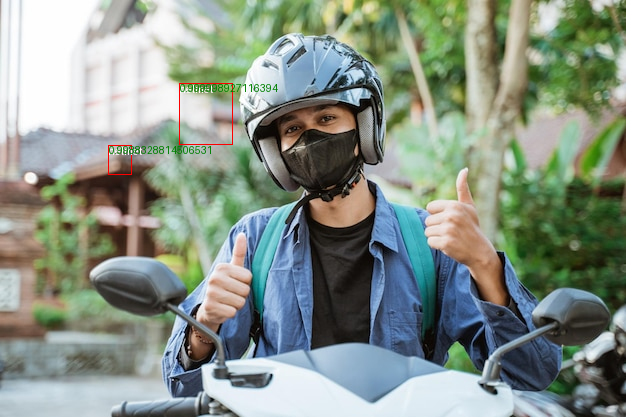

In [ ]:
def plot_results(image, results, threshold=0.7):
    image = Image.fromarray(np.uint8(image))
    draw = ImageDraw.Draw(image)
    for result in results:
        score = result["score"]
        label = result["label"]
        box = list(result["box"].values())
        if score > threshold:
            x, y, x2, y2 = tuple(box)
            draw.rectangle((x, y, x2, y2), outline="red", width=1)
            draw.text((x, y), label, fill="white")
            draw.text(
                (x + 0.5, y - 0.5),
                text=str(score),
                fill="green" if score > 0.7 else "red",
            )
    return image

plot_results(image, results)

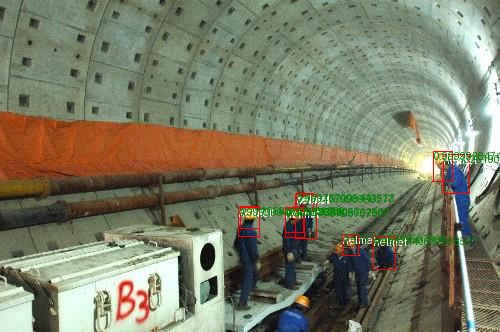

In [ ]:
def predict(image, pipeline, threshold=0.7):
    results = pipeline(image)
    return plot_results(image, results, threshold)


# Let's test for another test image

img = test_dataset[0]["image"]
predict(img, obj_detector)

  0%|          | 0/6 [00:00<?, ?it/s]

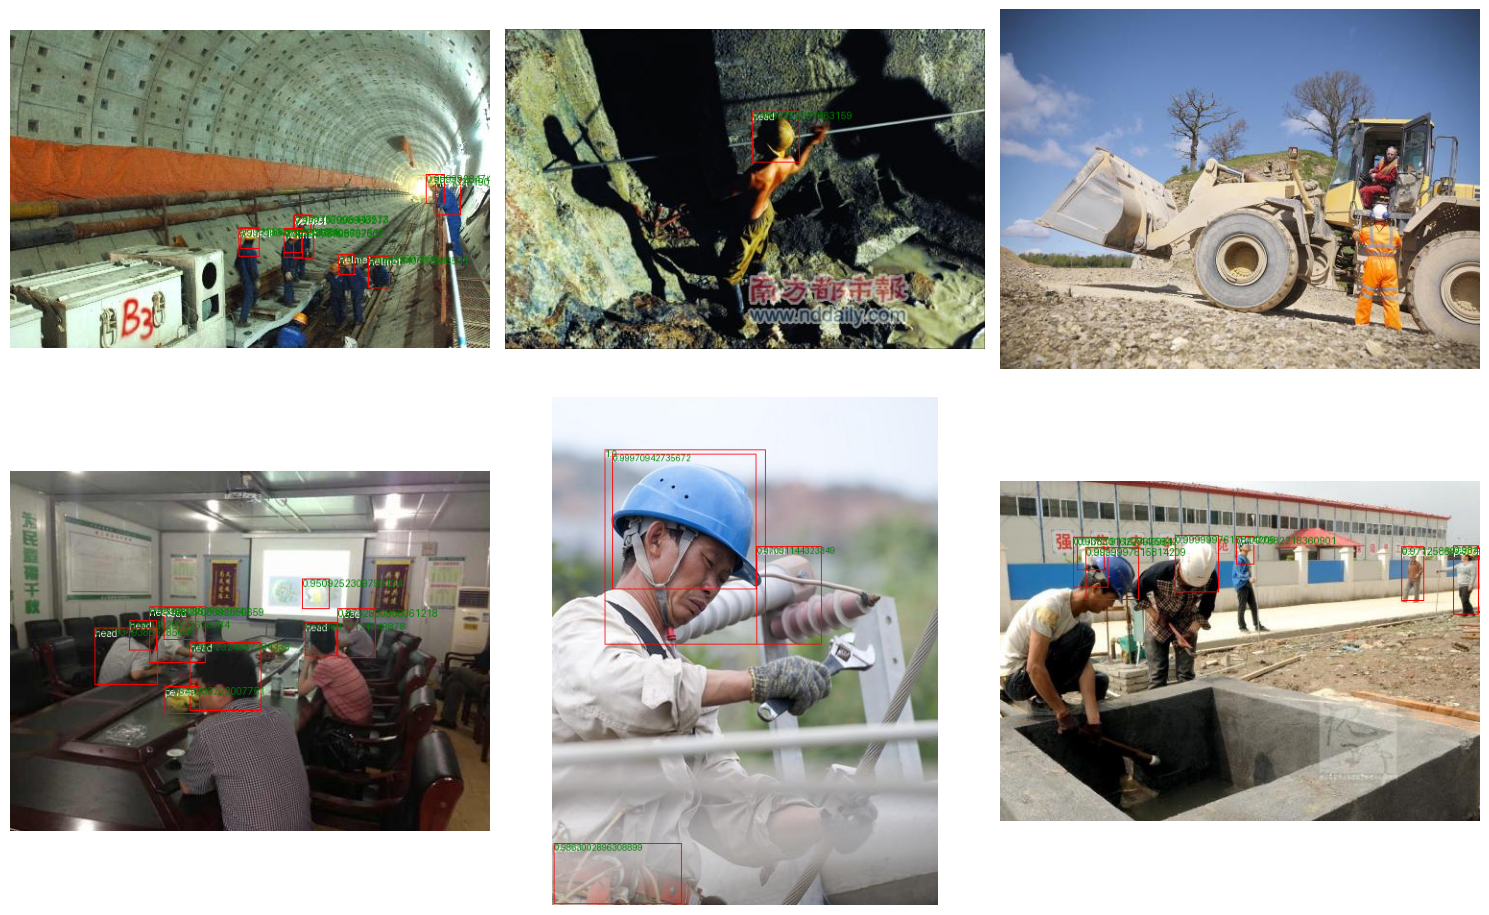

In [ ]:
from tqdm.auto import tqdm


def plot_images(dataset, indices):
    """
    Plot images and their annotations.
    """
    num_rows = len(indices) // 3
    num_cols = 3
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

    for i, idx in tqdm(enumerate(indices), total=len(indices)):
        row = i // num_cols
        col = i % num_cols

        # Draw image
        image = predict(dataset[idx]["image"], obj_detector)

        # Display image on the corresponding subplot
        axes[row, col].imshow(image)
        axes[row, col].axis("off")

    plt.tight_layout()
    plt.show()


plot_images(test_dataset, range(6))